In [1]:
import numpy as np
import scipy
from scipy import stats

import pandas as pd

import pymc3 as pm
import tensorflow as tf
tf.config.experimental.set_visible_devices([], 'GPU')
import tensorflow_probability as tfp
tfd = tfp.distributions

import arviz as az
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import ipywidgets as ipyw

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Define colors 
viridish = [(0.2823529411764706, 0.11372549019607843, 0.43529411764705883, 1.0),
            (0.1450980392156863, 0.6705882352941176, 0.5098039215686274, 1.0),
            (0.6901960784313725, 0.8666666666666667, 0.1843137254901961, 1.0)]

# Bayesian modeling notes

These notebooks consist of my notes, codes and solutions to exercises from the book ["Bayesian modeling and computation in Python" (Martin et al., 2022)](https://bayesiancomputationbook.com/welcome.html)


## Linear models with interaction

### Data + EDA

In [11]:
# Get tips data
data = pd.read_csv('https://raw.githubusercontent.com/BayesianModelingandComputationInPython/BookCode_Edition1/main/data/tips.csv')

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_bill  244 non-null    float64
 1   tip         244 non-null    float64
 2   sex         244 non-null    object 
 3   smoker      244 non-null    object 
 4   day         244 non-null    object 
 5   time        244 non-null    object 
 6   size        244 non-null    int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 13.5+ KB


In [15]:
data.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


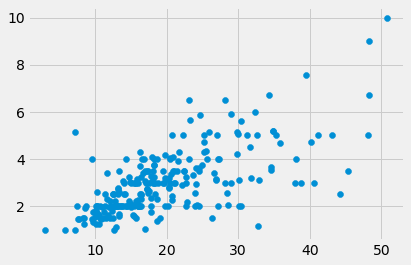

In [14]:
# Plot 
plt.scatter(data.total_bill, data.tip)
plt.show()

### Model with interaction

In [19]:
# Get observations
tips = data.tip
total_bill_centered = data.total_bill - data.total_bill.mean()
smoker = pd.Categorical(data.smoker).codes

In [84]:
# Model
with pm.Model() as model_with_interaction:
    
    beta = pm.Normal('beta', mu=0, sigma=1, shape=4)
    sigma = pm.HalfNormal('sigma', 1)
    
    ### Prior params ###
    mu = (beta[0]
        + beta[1] * total_bill_centered
        + beta[2] * smoker
        + beta[3] * total_bill_centered * smoker
    )
    
    obs = pm.Normal('obs', mu, sigma, observed=tips)
    
    trace_interaction = pm.sample(1000, tune=1000, target_accept=.95)
    
    inf_data_interaction = az.from_pymc3(trace_interaction)

C:\Users\aleks\AppData\Local\Temp/ipykernel_27644/3395370581.py:16: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_interaction = pm.sample(1000, tune=1000, target_accept=.95)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.


In [87]:
# Summarize
az.summary(inf_data_interaction).round(1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],3.1,0.1,2.9,3.2,0.0,0.0,2735.0,2961.0,1.0
beta[1],0.1,0.0,0.1,0.2,0.0,0.0,2243.0,2402.0,1.0
beta[2],-0.1,0.1,-0.4,0.1,0.0,0.0,2779.0,2690.0,1.0
beta[3],-0.1,0.0,-0.1,-0.0,0.0,0.0,2182.0,2244.0,1.0
sigma,1.0,0.0,0.9,1.1,0.0,0.0,3566.0,2636.0,1.0


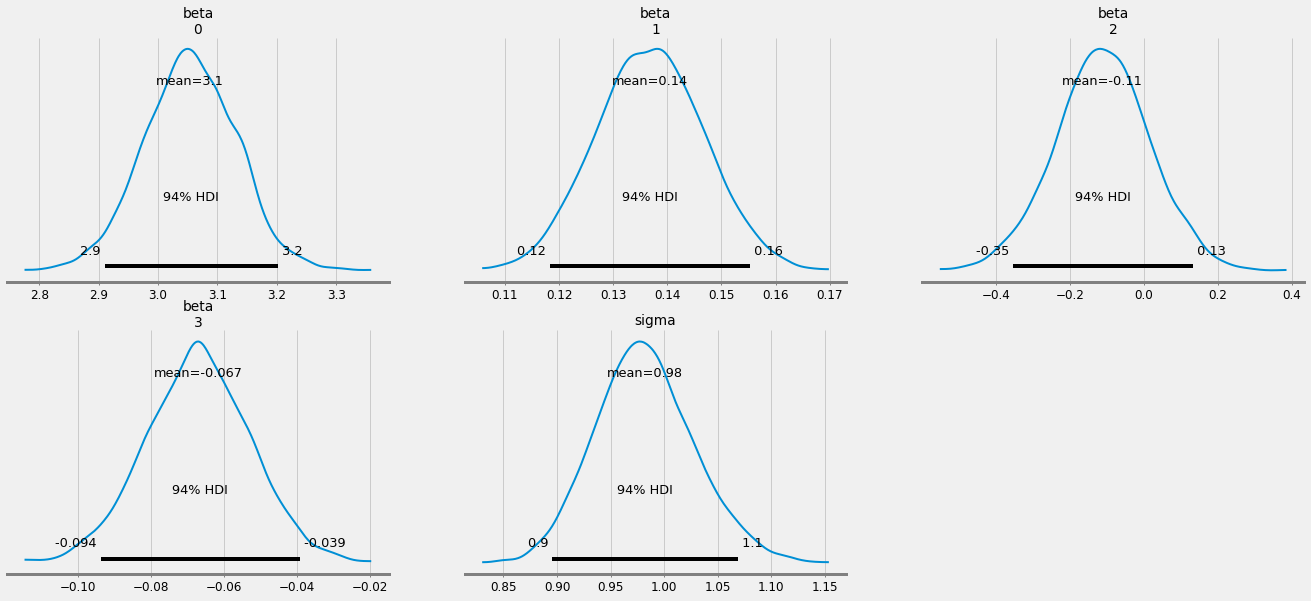

In [88]:
# Plot posterior
az.plot_posterior(
    inf_data_interaction, 
#     var_names=['beta_0', 'beta_1', 'beta_2', 'sigma'],
    textsize=12, 
    lw=2
)
plt.show()

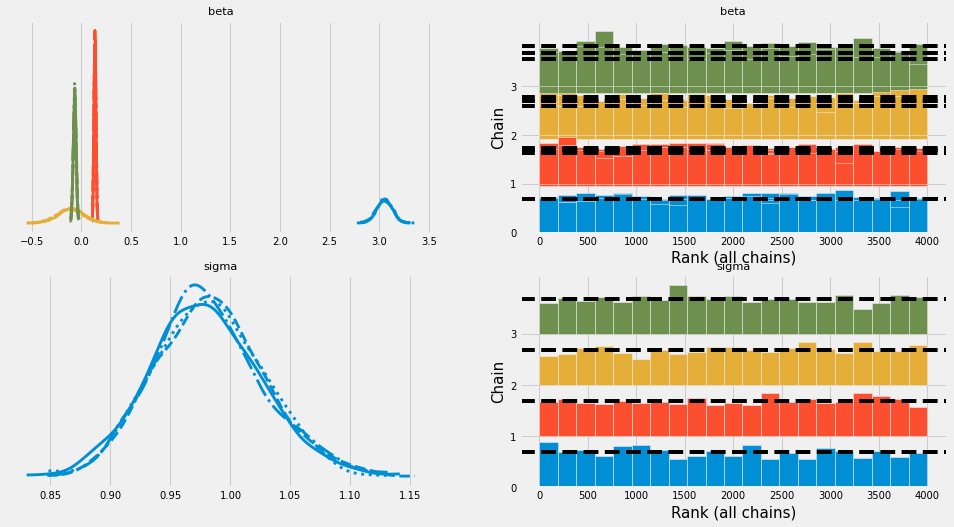

In [89]:
# Plot traces
az.plot_trace(
    inf_data_interaction, 
#     var_names=['beta_0', 'beta_1', 'beta_2', 'sigma'],
    compact=True, 
    figsize=(15, 8),
    divergences="bottom", 
    kind="rank_bars")
plt.show()

Chains and ranks look decent, but not perfect.

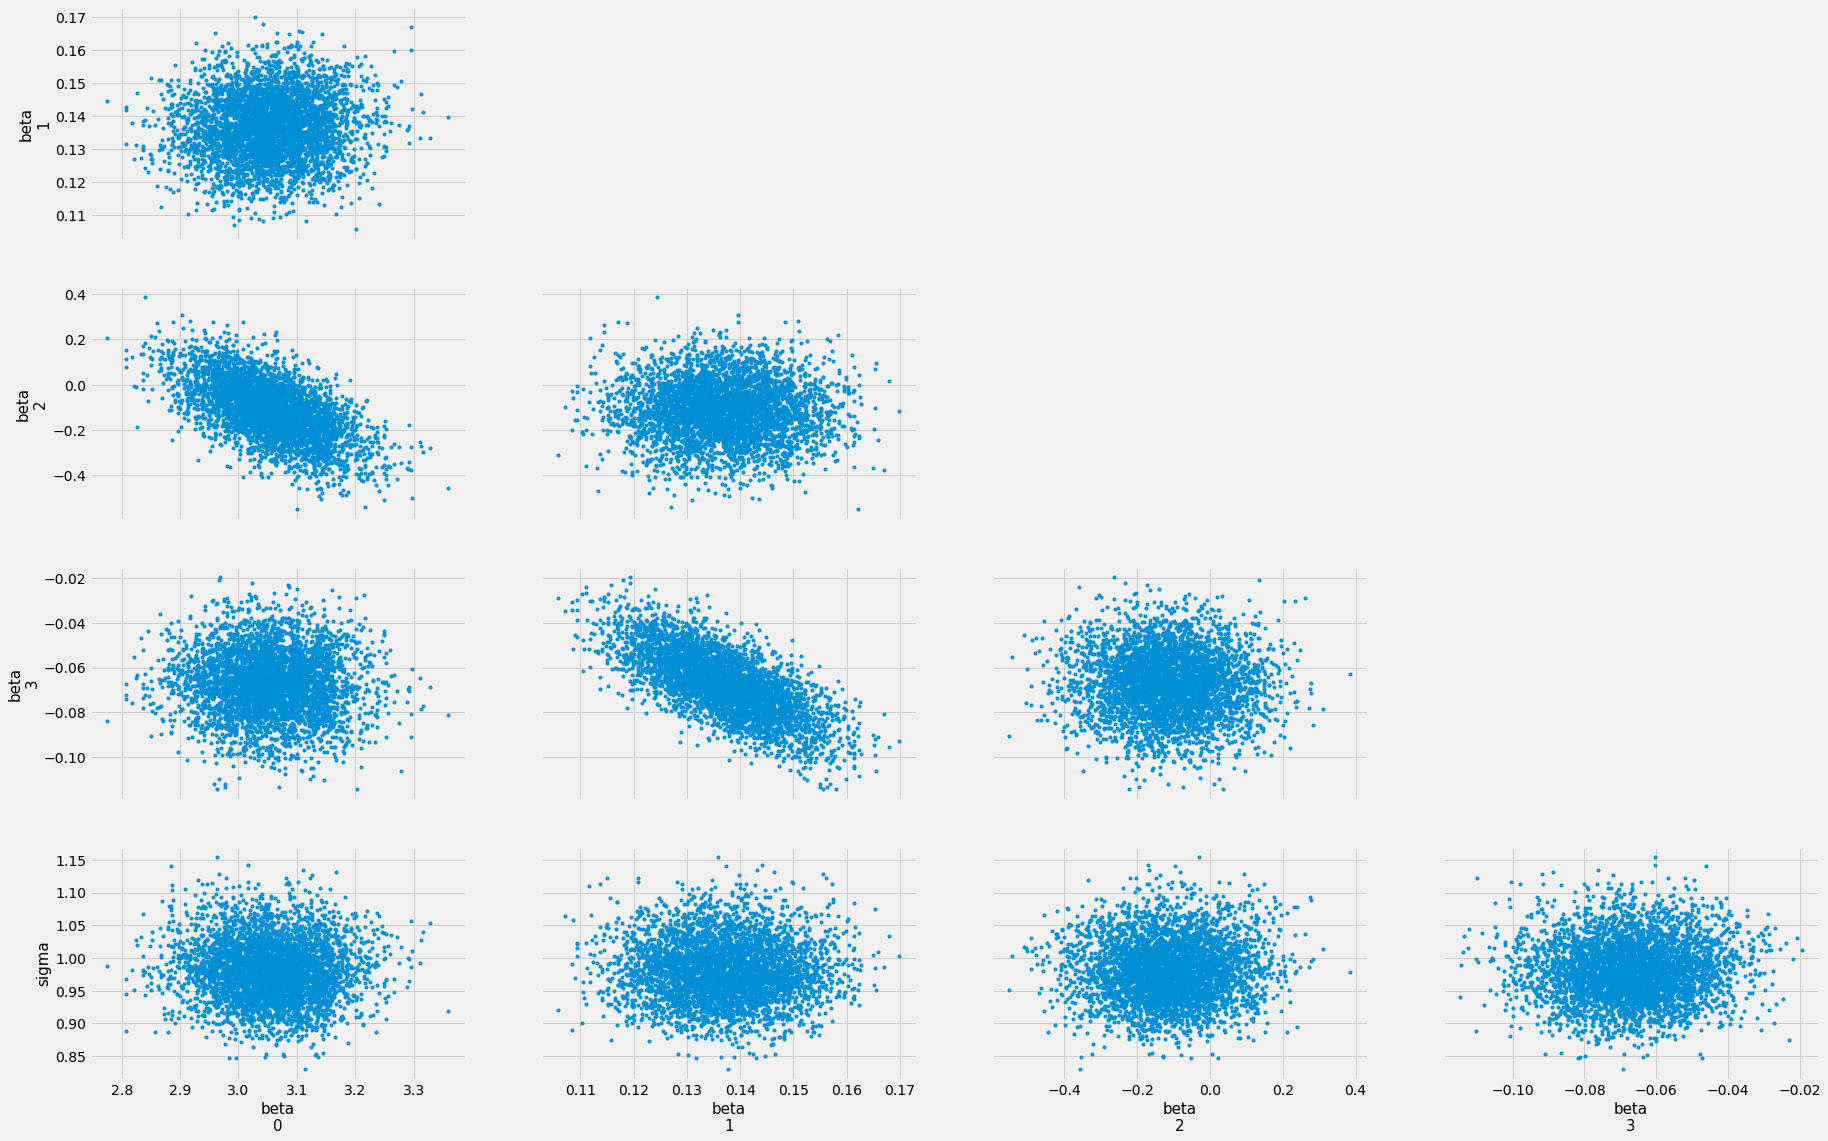

In [90]:
# Check divergences
az.plot_pair(inf_data_interaction, divergences=True)
plt.show()

AxesSubplot(0.08,0.07;0.87x0.81)


C:\Users\aleks\anaconda3\envs\tfp-pymc3-full\lib\site-packages\arviz\plots\hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
C:\Users\aleks\anaconda3\envs\tfp-pymc3-full\lib\site-packages\arviz\plots\hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


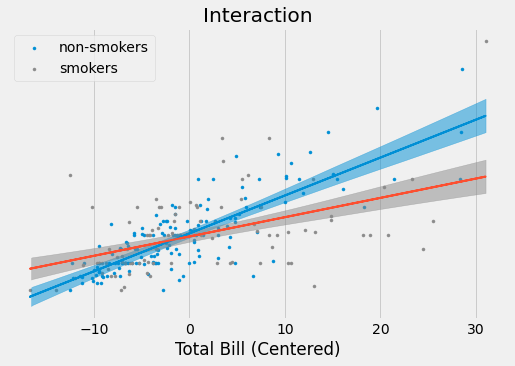

In [91]:
beta_0 = trace_interaction['beta'][:, 0]
beta_1 = trace_interaction['beta'][:, 1]
beta_2 = trace_interaction['beta'][:, 2]
beta_3 = trace_interaction['beta'][:, 3]

# Because smoker=0 I am ommiting the terms including the smoker covariate
pred_y_non_smokers = (beta_0 +
                      beta_1 * total_bill_centered.values[:, None])

# Because x1=1 I am ommiting x1
pred_y_smokers = (beta_0 +
                  beta_1 * total_bill_centered.values[:, None] +
                  beta_2 +
                  beta_3 * total_bill_centered.values[:, None])

_, ax = plt.subplots(1, figsize=(8, 5))
print(ax)

ax.scatter(total_bill_centered[smoker==0], tips[smoker==0], label='non-smokers', marker='.')
ax.scatter(total_bill_centered[smoker==1], tips[smoker==1], label='smokers', marker='.', c="C4")
ax.set_xlabel('Total Bill (Centered)')
ax.set_yticks([])

ax.set_title('Interaction')

ax.plot(total_bill_centered, pred_y_non_smokers.mean(1), lw=2)
ax.plot(total_bill_centered, pred_y_smokers.mean(1), lw=2)

az.plot_hdi(total_bill_centered, pred_y_non_smokers.T, color='C0', ax=ax)
az.plot_hdi(total_bill_centered, pred_y_smokers.T, ax=ax, color="C4")

plt.legend()
plt.show()